In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-analitics/train.csv
/kaggle/input/churn-analitics/test.csv


# Прогнозирование Оттока Клиентов (Customer Churn Prediction)

## Введение | Introduction

**RU:**  
Данный проект демонстрирует полный end-to-end цикл решения задачи бинарной классификации — прогнозирования оттока клиентов (Customer Churn).  
Основной фокус сделан на корректной валидации, устойчивости модели и интерпретируемости результатов, что критично для прикладных задач в телекоме и банковском секторе.

**EN:**  
This project demonstrates a full end-to-end pipeline for a binary classification problem — customer churn prediction.  
The main focus is placed on proper validation strategy, model robustness, and interpretability, which are critical for real-world applications in telecom and banking.

---

## Метрика и стратегия оценки | Metric & Validation Strategy

**RU:**  
Основной метрикой выбрана **ROC-AUC**, так как она:
- является threshold-independent;
- устойчива к дисбалансу классов;
- соответствует метрике соревнования Kaggle.

Для оценки качества использовалась **Stratified K-Fold Cross-Validation**, результаты представлены как *mean ± std*.

**EN:**  
The primary evaluation metric is **ROC-AUC**, as it:
- is threshold-independent;
- is robust to class imbalance;
- matches the Kaggle competition metric.

Model performance is evaluated using **Stratified K-Fold Cross-Validation**, reported as *mean ± std*.

---

## Моделирование | Modeling

**RU:**  
В рамках проекта были обучены и сравнены следующие модели:
- Logistic Regression (baseline)
- Random Forest
- Gradient Boosting, XGBoost, LightGBM, CatBoost

Подбор гиперпараметров выполнялся с использованием кросс-валидации.

**EN:**  
The following models were trained and compared:
- Logistic Regression (baseline)
- Random Forest
- Gradient Boosting, XGBoost, LightGBM, CatBoost

Hyperparameter tuning was performed using cross-validation.

---

## Ключевые результаты | Key Results

**RU:**  
Модель **XGBoost** показала наилучшее качество по метрике ROC-AUC и продемонстрировала стабильные результаты на кросс-валидации.

Дополнительно был проведён анализ бизнес-порогов для демонстрации возможного применения модели в production-сценариях (не используется для оценки Kaggle).

**EN:**  
The **XGBoost** model achieved the best ROC-AUC score and demonstrated stable performance across cross-validation folds.

Additionally, threshold analysis was performed to illustrate potential production use cases (not used for Kaggle evaluation).

---

## Интерпретация и бизнес-контекст | Interpretability & Business Context

**RU:**  
Для интерпретации модели использовались:
- permutation feature importance;
- анализ влияния ключевых признаков.

Модель возвращает **калиброванные вероятности**, которые могут использоваться для:
- приоритизации клиентов;
- cost-sensitive решений;
- настройки бизнес-порогов.

**EN:**  
Model interpretability was addressed using:
- permutation feature importance;
- analysis of key feature impacts.

The model outputs **calibrated probabilities** suitable for:
- customer prioritization;
- cost-sensitive decision-making;
- business threshold tuning.

---

## Ограничения и дальнейшие шаги | Limitations & Next Steps

**RU:**  
- Возможен dataset shift между train и production данными.
- Модель не учитывает временную динамику клиентов.

Потенциальные улучшения:
- time-based validation;
- monitoring data drift;
- регулярное переобучение модели.

**EN:**  
- Potential dataset shift between training and production data.
- No explicit temporal modeling.

Future improvements include:
- time-based validation;
- data drift monitoring;
- periodic model retraining.


In [24]:
# ======================
# Global settings
# ======================
SEED = 42
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

# ======================
# Core libraries
# ======================
import numpy as np
import pandas as pd
import os

# ======================
# Visualization
# ======================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14

# ======================
# Modeling & Validation
# ======================
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ======================
# Preprocessing & Encoding
# ======================
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

# ======================
# Metrics
# ======================
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve, 
    confusion_matrix, 
    classification_report,
    f1_score
)

print("Все библиотеки загружены. Среда готова к работе.")

Все библиотеки загружены. Среда готова к работе.


## Загрузка и первичная проверка данных | Data Loading & Initial Validation

**RU:**  
На данном этапе производится загрузка обучающего и тестового датасетов из среды Kaggle.  
Дополнительно выполняется базовая валидация данных для проверки корректности чтения файлов и согласованности структуры между train и test выборками.

Особое внимание уделяется:
- корректности разделителя (`sep`);
- размерности таблиц;
- типам данных и наличию пропусков.

Данные проверки позволяют на раннем этапе выявить потенциальные проблемы качества данных и избежать скрытых ошибок в дальнейшем моделировании.

**EN:**  
At this stage, the training and test datasets are loaded from the Kaggle environment.  
Basic data validation is performed to ensure correct file parsing and structural consistency between train and test datasets.

Special attention is paid to:
- correct delimiter (`sep`) usage;
- dataset dimensionality;
- data types and missing values.

These sanity checks help detect potential data quality issues early and prevent silent errors during subsequent modeling steps.


In [4]:
# ======================
# Data loading
# ======================
train_path = '/kaggle/input/churn-analitics/train.csv'
test_path  = '/kaggle/input/churn-analitics/test.csv'

# Загружаем с учетом разных разделителей
train = pd.read_csv(train_path, sep=';')
test  = pd.read_csv(test_path, sep=',')

# ==========================================
# ДОПОЛНЕНИЕ: Сохранение метаданных и нормализация
# ==========================================
# 1. Сразу чистим пробелы в названиях и приводим к нижнему регистру
train.columns = train.columns.str.strip().str.lower()
test.columns = test.columns.str.strip().str.lower()

# 2. Сохраняем ID теста для будущего сабмита, пока мы их не удалили
# (используем .copy(), чтобы связь не разорвалась)
test_ids = test['id'].copy() 

# ======================
# Basic data validation
# ======================
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Вывод основной информации
display(train.head())
print("-" * 30)
train.info()

Train shape: (2499, 23)
Test shape: (830, 22)


,id,sex,age,state,account length,phone number,plans,number vmail messages,total day minutes,total day calls,...,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,total charge,customer service calls,churn
0,10001,Female,35.0,MN,150,415 695 24 37,Voice mail,28,174.4,75.0,...,14.44,201.6,130.0,9.07,11.0,4.0,2.97,56.13,1,0
1,10010,Female,43.0,AR,87,408 673 99 45,NaN,0,185.8,119.0,...,16.35,200.0,96.0,9.00,6.6,4.0,1.78,58.72,1,0
2,10029,Female,39.0,ND,180,415 693 30 62,NaN,0,224.9,105.0,...,21.25,216.1,73.0,9.72,6.7,5.0,1.81,71.01,3,1
3,10030,Female,36.0,AL,200,408 248 27 61,NaN,0,128.2,87.0,...,11.32,177.6,123.0,7.99,11.2,2.0,3.02,44.12,1,0
4,10122,Male,37.0,DE,122,510 297 57 75,NaN,0,157.1,134.0,...,15.72,197.2,59.0,8.87,8.5,5.0,2.30,53.6,4,1


------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2499 entries, 0 to 2498
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2499 non-null   int64  
 1   sex                     2499 non-null   object 
 2   age                     1757 non-null   float64
 3   state                   2499 non-null   object 
 4   account length          2499 non-null   int64  
 5   phone number            2499 non-null   object 
 6   plans                   860 non-null    object 
 7   number vmail messages   2499 non-null   int64  
 8   total day minutes       2499 non-null   object 
 9   total day calls         2499 non-null   object 
 10  total day charge        2499 non-null   float64
 11  total eve minutes       2499 non-null   float64
 12  total eve calls         2499 non-null   float64
 13  total eve charge        2499 non-null   float64
 14  total nig

## Анализ целевой переменной (Churn) | Target Variable Analysis

**RU:**  
Прогнозирование оттока клиентов — это типичная задача с **несбалансированными классами**.  
На данном этапе анализируется распределение целевой переменной, чтобы определить стратегию моделирования, необходимость балансировки классов и подход к выбору метрик.

Особое внимание уделяется:
- количеству наблюдений в каждом классе;
- процентному распределению;
- визуальному представлению через круговую диаграмму;
- оценке степени дисбаланса (соотношение мажоритарный/миноритарный).

**EN:**  
Customer churn prediction is typically a **class-imbalanced** problem.  
At this stage, we analyze the target variable distribution to inform modeling strategy, class balancing requirements, and metric selection.

Key points:
- number of observations per class;
- percentage distribution;
- visualization using a pie chart;
- imbalance assessment (majority/minority ratio).


--- АНАЛИЗ СБАЛАНСИРОВАННОСТИ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (CHURN) ---
Количество наблюдений по классам:
churn
0    2137
1     362
Name: count, dtype: int64

Процентное распределение:
churn
0    85.51
1    14.49 %


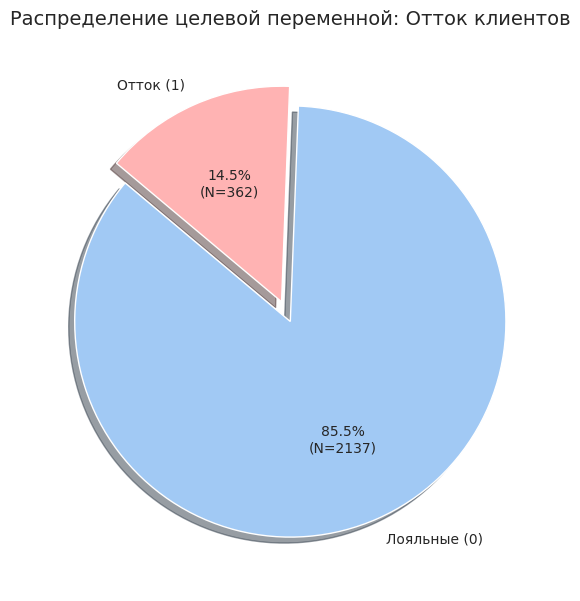


Общее количество наблюдений: 2499
Соотношение классов: 5.90:1
Статус: СИЛЬНЫЙ ДИСБАЛАНС


In [5]:
# ======================
# Target variable analysis (Updated for lowercase columns)
# ======================

churn_counts = train['churn'].value_counts()
churn_distribution = train['churn'].value_counts(normalize=True) * 100
total_n = len(train)

print("--- АНАЛИЗ СБАЛАНСИРОВАННОСТИ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (CHURN) ---")
print(f"Количество наблюдений по классам:")
print(churn_counts)
print(f"\nПроцентное распределение:")
print(churn_distribution.round(2).to_string() + " %")

# ======================
# Visualization
# ======================
plt.figure(figsize=(7, 7))

# Функция для вывода N и % на графике
def autopct_format(value):
    count = int(round(value * total_n / 100))
    return f'{value:.1f}%\n(N={count})'

explode = [0, 0.1]
labels = ['Лояльные (0)', 'Отток (1)']

plt.pie(
    churn_counts,
    labels=labels,
    autopct=autopct_format,
    startangle=140,
    explode=explode,
    colors=['#a1c9f4', '#ffb3b3'],
    shadow=True
)
plt.title('Распределение целевой переменной: Отток клиентов', fontsize=14, pad=20)
plt.show()

# ======================
# Conclusion (Value for Portfolio)
# ======================
ratio = churn_counts.max() / churn_counts.min()
imbalance_type = 'сбалансированные' if ratio < 1.5 else 'умеренный дисбаланс' if ratio < 4 else 'сильный дисбаланс'

print(f"\nОбщее количество наблюдений: {total_n}")
print(f"Соотношение классов: {ratio:.2f}:1")
print(f"Статус: {imbalance_type.upper()}")

## Выбор метрик | Metric Selection

**RU:**  
Доля ушедших клиентов составляет 14.48%, что указывает на **сильный дисбаланс классов**.  
В связи с этим **Accuracy не подходит** для оценки модели, так как даже простая константная модель, предсказывающая "не ушёл", даст высокий показатель.  

Для оценки эффективности модели используются следующие метрики:  
- **ROC-AUC** — оценивает общую различительную способность модели, threshold-independent.  
- **F1-Score, Precision, Recall** — используются для анализа бизнес-порогов, особенно важны при приоритизации ухода клиентов и планировании удерживающих кампаний.

**EN:**  
The churn rate is 14.48%, indicating a **strong class imbalance**.  
Hence, **Accuracy is not suitable** for model evaluation, as a simple constant model predicting "no churn" would yield high accuracy.

The chosen evaluation metrics are:  
- **ROC-AUC** — measures overall discriminative ability, threshold-independent.  
- **F1-Score, Precision, Recall** — used for business threshold analysis, particularly important for customer retention prioritization and campaign planning.


## Диагностика числовых признаков с некорректным типом | Numeric Feature Diagnostics

**RU:**  
На этом этапе выполняется диагностика признаков, которые имеют числовую природу, но представлены в формате `object`.  
Цель — выявить "грязные" значения (например, пробелы, строки, специальные символы), которые мешают корректной конвертации в числовой формат.  
Результаты диагностики позволяют заранее планировать очистку данных и предотвращать ошибки при обучении модели.

**EN:**  
At this stage, we diagnose features that are numeric in nature but stored as `object` type.  
The goal is to detect "dirty" values (e.g., spaces, strings, special characters) that prevent correct numeric conversion.  
The results help plan data cleaning and prevent errors during model training.


In [6]:
# ======================
# Dirty numeric value diagnostics
# ======================
# RU: Столбцы, которые должны быть числовыми
# EN: Columns that should be numeric

charge_minute_cols = [
    "total day minutes", "total day calls", "total night minutes",
    "total intl minutes", "total charge", "customer service calls",
    "total day charge", "total eve charge", "total night charge",
    "total intl charge"
]

print("--- АНАЛИЗ ВСЕХ ГРЯЗНЫХ НЕЧИСЛОВЫХ ЗНАЧЕНИЙ ---")
# RU: Словарь для хранения найденных аномалий
# EN: Dictionary to store detected anomalies

dirty_data_found = {}
for col in charge_minute_cols:
    # RU: Приводим колонку к строковому типу
    # EN: Convert column to string type

    series_str = train[col].astype(str)

    # RU: Проверяем, что не является числом (NaN при ошибке)
    # EN: Check what cannot be converted to numeric (NaN if error)

    numeric_check = pd.to_numeric(series_str, errors='coerce')
    # RU: Маска для всех, кто не смог стать числом
    # EN: Mask for all values that could not be converted to numeric

    mask_dirty = numeric_check.isnull()
    # RU: Исходные строковые значения, которые не являются числами
    # EN: Original string values that are not numeric

    non_numeric_values = series_str[mask_dirty].unique()
    # RU: Исключаем строковый 'nan' (известный пропуск)
    # EN: Exclude string 'nan' (known missing)

    final_anomalies = [val for val in non_numeric_values if val.lower() != 'nan']

    if final_anomalies:
        dirty_data_found[col] = final_anomalies

# RU: Выводим результаты
# EN: Output the results

if dirty_data_found:
    print("\nОБНАРУЖЕНЫ СЛЕДУЮЩИЕ УНИВЕРСАЛЬНЫЕ АНОМАЛИИ:")
    for col, values in dirty_data_found.items():
        count = sum(train[col].astype(str).str.contains('|'.join([str(v) for v in values]), case=False, na=False))
        print(f"\n{col} (Общее количество: {count} шт. | Уникальные: {len(values)}):")
        print(values)
else:
    print("\nНечисловых строковых аномалий (кроме строкового 'nan') не обнаружено.")

--- АНАЛИЗ ВСЕХ ГРЯЗНЫХ НЕЧИСЛОВЫХ ЗНАЧЕНИЙ ---

ОБНАРУЖЕНЫ СЛЕДУЮЩИЕ УНИВЕРСАЛЬНЫЕ АНОМАЛИИ:

total day minutes (Общее количество: 37 шт. | Уникальные: 37):
['191.o', '226,7', '97,5', '168,4', '198,3', '252,4', '186,1', '229,6', '125,3', '1o9.1', '198,5', '137,4', '200,3', '207,9', '172,3', '157,9', '152,2', '142,5', '175,2', '193,6', '98,0', '128,1', '258,0', '230,7', '243,4', '219,5', '278.o', '16o.2', '170,1', '213,6', '145,0', '266,1', '2o7.1', '155,0', '295,0', '159.o', '286,4']

total day calls (Общее количество: 3 шт. | Уникальные: 2):
['1o4.o', '1o6.o']

total night minutes (Общее количество: 9 шт. | Уникальные: 9):
['l86.9', 'l94.7', '269.l', 'l72.3', 'l58.6', 'l67.8', 'l79.7', 'l52.8', 'l47.7']

total intl minutes (Общее количество: 26 шт. | Уникальные: 22):
['15,3', '8,4', '10,3', '9,5', '11,7', '12,3', '11,1', '8,9', '14,0', '11,5', '11,2', '17,0', '7,1', '11,0', '8,0', '9,1', '6,3', '11,3', '11,8', '9,4', '12,5', '7,3']

total charge (Общее количество: 11 шт. | Уникальные

## Feature Engineering | Feature Engineering

### Очистка и приведение числовых признаков | Cleaning & Converting Numeric Features

**RU:**  
В ходе EDA было выявлено, что ряд числовых признаков представлен в строковом формате и содержит системные ошибки форматирования: запятые вместо точек, символы `'o'` вместо `'0'` и `'l'` вместо `'1'`.  

Для этих признаков выполняется:
- нормализация строк;
- конвертация в числовой тип;
- пересчёт агрегированного признака `Total charge` как суммы компонентных стоимостей (`Total day charge`, `Total eve charge`, `Total night charge`, `Total intl charge`) для согласованности данных и устранения влияния строковых аномалий.

**EN:**  
During EDA, it was found that several numeric features were stored as strings and contained systematic formatting errors: commas instead of dots, `'o'` instead of `'0'` and `'l'` instead of `'1'`.  

For these features, we perform:
- string normalization;
- conversion to numeric type;
- recalculation of the aggregate feature `Total charge` as the sum of its components (`Total day charge`, `Total eve charge`, `Total night charge`, `Total intl charge`) to ensure data consistency and eliminate the effect of string anomalies.


In [7]:
# ======================
# Dirty numeric columns
# ======================
# RU: Признаки с форматными строковыми ошибками
# EN: Features with formatting string errors
dirty_numeric_cols = [
    "total day minutes",
    "total day calls",
    "total night minutes",
    "total intl minutes",
    "customer service calls"
]

# RU: Функция для очистки строковых ошибок
# EN: Function to clean string-based numeric errors
def clean_numeric_strings(series: pd.Series) -> pd.Series:
    return (
        series
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace('o', '0', regex=False)
        .str.replace('l', '1', regex=False)
    )

# RU: Применяем очистку и конвертацию к числовому типу для train и test
# EN: Apply cleaning and convert to numeric for train and test
for col in dirty_numeric_cols:
    train[col] = pd.to_numeric(clean_numeric_strings(train[col]), errors='coerce')
    test[col]  = pd.to_numeric(clean_numeric_strings(test[col]), errors='coerce')

# ======================
# Total charge recalculation
# ======================
# RU: Компонентные признаки стоимости
# EN: Component charge features
charge_components = [
    "total day charge",
    "total eve charge",
    "total night charge",
    "total intl charge"
]

# RU: Убедимся, что компоненты числовые
# EN: Ensure components are numeric
for col in charge_components:
    train[col] = pd.to_numeric(train[col], errors='coerce')
    test[col]  = pd.to_numeric(test[col], errors='coerce')

# RU: Пересчёт агрегированного признака Total charge
# EN: Recalculate the aggregated feature Total charge
train["total charge"] = train[charge_components].sum(axis=1)
test["total charge"]  = test[charge_components].sum(axis=1)

# RU: Проверка пропусков после преобразования
# EN: Check missing values after conversion
train[dirty_numeric_cols + ["total charge"]].isnull().sum()


total day minutes         0
total day calls           0
total night minutes       0
total intl minutes        0
customer service calls    0
total charge              0
dtype: int64

## Импутация пропусков в признаке `Plans` | Imputation of Missing Values in `Plans`

**RU:**  
Признак `Plans` содержит 1639 пропущенных значений и отражает набор подключённых услуг абонента.  

Для восстановления пропусков используется **поведенческая логика**, основанная на фактическом использовании услуг клиента:

- международные звонки (`Total intl minutes`, `Total intl calls`, `Total intl charge`);
- голосовая почта (`Number vmail messages`).

Такой подход позволяет:
- восстановить признак без искажения распределения;  
- исключить утечку целевой переменной (`Churn`).

**EN:**  
The `Plans` feature has 1639 missing values and represents the set of services subscribed by the customer.  

To impute missing values, we use **behavioral logic** based on actual service usage:

- international calls (`Total intl minutes`, `Total intl calls`, `Total intl charge`);  
- voicemail (`Number vmail messages`).

This approach allows us to:
- impute the feature without distorting its distribution;  
- avoid target leakage (`Churn`).


In [8]:
# ======================
# Behavioral-based imputation for 'Plans'
# ======================
# RU: Функция определения плана на основе использования услуг
# EN: Function to infer plan based on service usage
def infer_plan(row):
    uses_international = (row["total intl minutes"] > 0) or \
                         (row["total intl calls"] > 0) or \
                         (row["total intl charge"] > 0)  # RU: Усиленная логика
                                                          # EN: Enhanced logic
    uses_voicemail = row["number vmail messages"] > 0
    
    if uses_international and uses_voicemail:
        return "international, voice mail"
    elif uses_international:
        return "international"
    elif uses_voicemail:
        return "voice mail"
    else:
        return "no plan"

# RU: Применение функции только к пропущенным значениям 'Plans'
# EN: Apply the function only to missing 'Plans' values
for df in [train, test]:
    plans_na_mask = df['plans'].isna()
    df.loc[plans_na_mask, 'plans'] = df[plans_na_mask].apply(infer_plan, axis=1)

print("Восстановление пропущенных значений в 'Plans' завершено с использованием поведенческой логики.")


Восстановление пропущенных значений в 'Plans' завершено с использованием поведенческой логики.


## Импутация числовых признаков: Age с помощью KNN | Numeric Feature Imputation: Age using KNN

**RU:**  
Признак `Age` имеет пропущенные значения.  
Так как возраст клиента, вероятно, зависит от множества поведенческих факторов (расходы, активность, подключённые планы), мы используем **K-Nearest Neighbors (KNN) Imputer**.  

Принцип работы:
- для каждого пропущенного значения находятся **5 ближайших соседей** по выбранным признакам;  
- используется **среднее значение возраста соседей** для заполнения пропуска.  

Этот метод точнее, чем заполнение медианой, и учитывает структуру данных.

**EN:**  
The `Age` feature has missing values.  
Since customer age likely depends on behavioral factors (spending, activity, subscribed plans), we use **K-Nearest Neighbors (KNN) Imputer**.  

How it works:
- for each missing value, **5 nearest neighbors** are found based on selected features;  
- the **average age of neighbors** is used to impute the missing value.  

This method is more accurate than median imputation and accounts for data structure.


In [9]:
from sklearn.impute import KNNImputer
import numpy as np

# ======================
# 0. Удаление идентификаторов | Remove identifiers
# ======================
id_cols_to_drop = ['id', 'phone number']
train = train.drop(id_cols_to_drop, axis=1, errors='ignore')
test = test.drop(id_cols_to_drop, axis=1, errors='ignore')
print("Идентификаторы 'ID' и 'Phone number' удалены.")

# ======================
# 1. Подготовка данных для KNN Imputer | Prepare data for KNN Imputer
# ======================
temp_categorical_cols = ['plans', 'state', 'sex']

# Выбираем признаки для импутации Age (включаем категориальные и все числовые кроме Churn)
knn_features = temp_categorical_cols + list(train.select_dtypes(include=np.number).columns)
knn_features = [col for col in knn_features if col not in ['churn']]

knn_train = train[knn_features].copy()
knn_test = test[knn_features].copy()

# Временное кодирование категориальных признаков | Temporary encoding of categorical features
for col in temp_categorical_cols:
    if col in knn_train.columns:
        mapping = {name: i for i, name in enumerate(knn_train[col].unique())}
        knn_train[col] = knn_train[col].map(mapping)
        knn_test[col] = knn_test[col].map(mapping).fillna(-1)

# ======================
# 2. Применение KNN Imputer | Apply KNN Imputer
# ======================
imputer = KNNImputer(n_neighbors=5)
knn_train_imputed = imputer.fit_transform(knn_train)
knn_test_imputed = imputer.transform(knn_test)

knn_train_imputed = pd.DataFrame(knn_train_imputed, columns=knn_train.columns, index=train.index)
knn_test_imputed = pd.DataFrame(knn_test_imputed, columns=knn_test.columns, index=test.index)

# ======================
# 3. Обновление столбца Age | Update Age column
# ======================
train['age'] = knn_train_imputed['age']
test['age']  = knn_test_imputed['age']

print("Импутация Age с помощью KNN Imputer завершена.")
print(f"Количество NaN в Age после импутации (train): {train['age'].isnull().sum()}")
print(f"Количество NaN в Age после импутации (test): {test['age'].isnull().sum()}")


Идентификаторы 'ID' и 'Phone number' удалены.
Импутация Age с помощью KNN Imputer завершена.
Количество NaN в Age после импутации (train): 0
Количество NaN в Age после импутации (test): 0


## Приведение имен признаков к читаемому формату | Renaming Features for Readability

**RU:**  
Многие признаки содержат пробелы, что неудобно для работы с библиотеками машинного обучения.  
Чтобы повысить читаемость и совместимость с scikit-learn, XGBoost и другими библиотеками, приводим имена колонок к **snake_case**:

- пробелы заменяются на `_`;  
- все буквы в нижнем регистре;  
- удаляются специальные символы.  

**EN:**  
Many feature names contain spaces, which is inconvenient for machine learning libraries.  
To improve readability and compatibility with scikit-learn, XGBoost, and other libraries, we convert column names to **snake_case**:

- spaces → `_`;  
- all letters → lowercase;  
- remove special characters.


In [10]:
# RU: Приведение всех колонок к читаемым snake_case именам
# EN: Convert all column names to readable snake_case
def clean_column_names(df):
    df.columns = (
        df.columns
        .str.strip()                 # убрать пробелы в начале/конце
        .str.lower()                 # привести к нижнему регистру
        .str.replace(' ', '_', regex=False)  # пробелы → _
        .str.replace('-', '_', regex=False)  # дефисы → _
        .str.replace(r'[^\w_]', '', regex=True)  # убрать все спецсимволы кроме _
    )
    return df

train = clean_column_names(train)
test  = clean_column_names(test)

print("Имена признаков приведены к читаемому формату snake_case.")
print(train.columns)


Имена признаков приведены к читаемому формату snake_case.
Index(['sex', 'age', 'state', 'account_length', 'plans',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'total_charge', 'customer_service_calls', 'churn'],
      dtype='object')


## Анализ распределений числовых признаков | Numeric Feature Distribution Analysis

**RU:**  
После очистки данных и импутации пропусков проводится анализ распределений числовых признаков.  
Цель этапа — выявить:
- форму распределения (нормальность, асимметрия);
- наличие выбросов;
- потенциальную необходимость трансформаций.

**EN:**  
After data cleaning and missing value imputation, numeric feature distributions are analyzed.  
This step aims to:
- understand distribution shape (normality, skewness);
- detect outliers;
- assess the need for feature transformations.


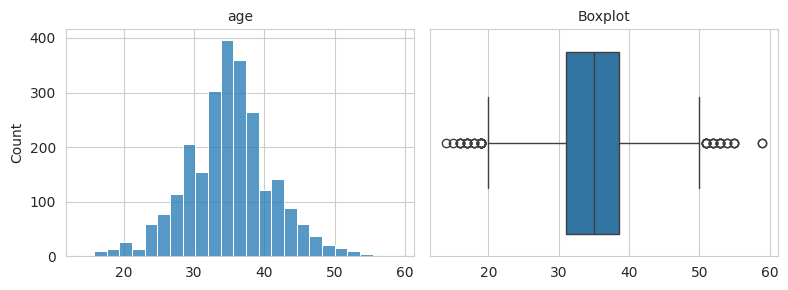

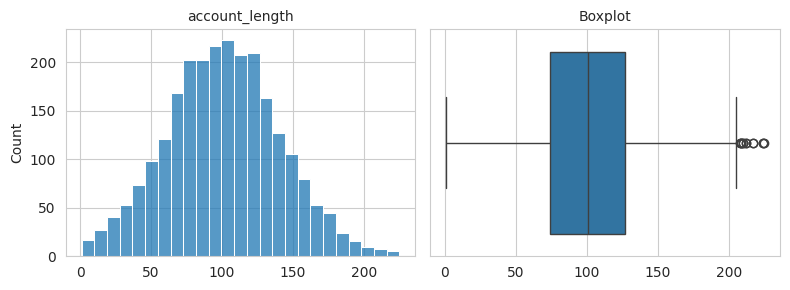

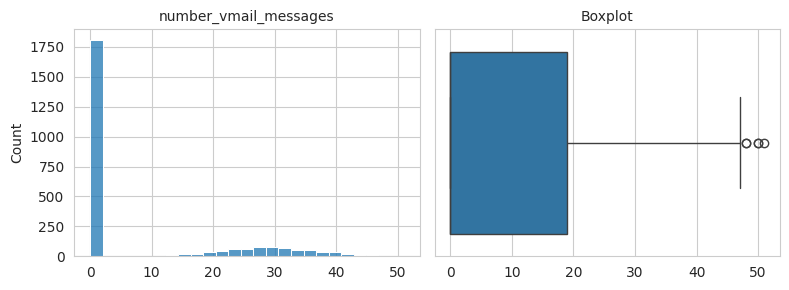

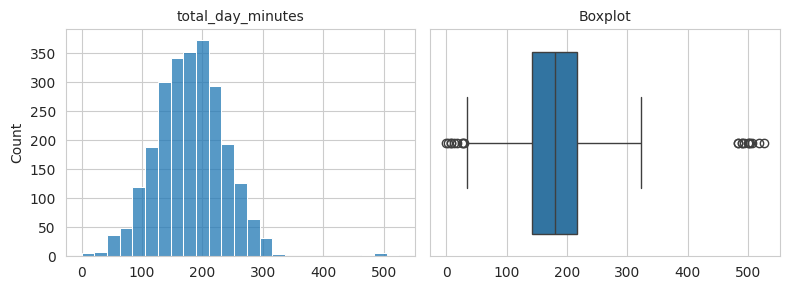

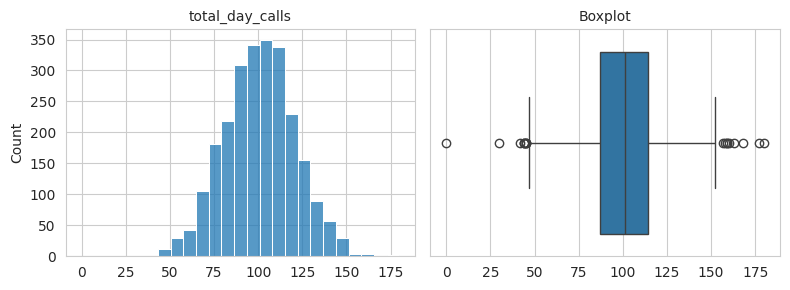

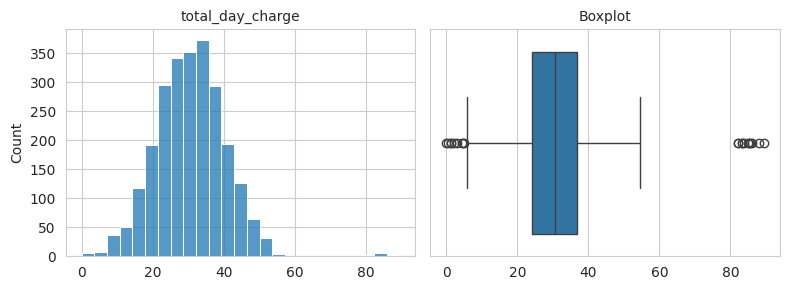

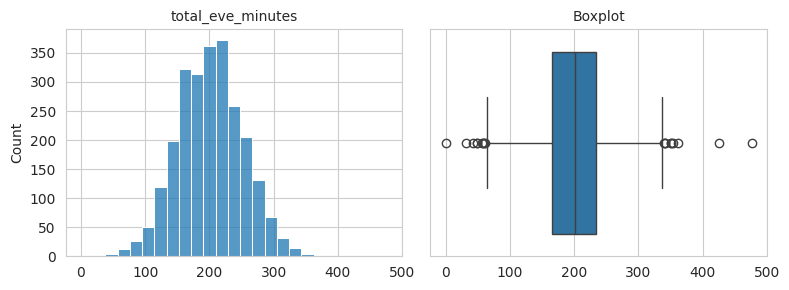

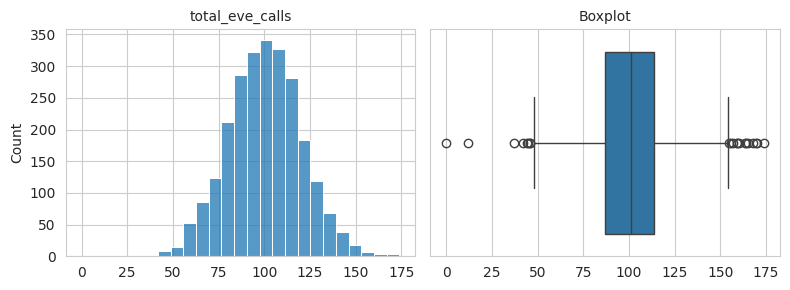

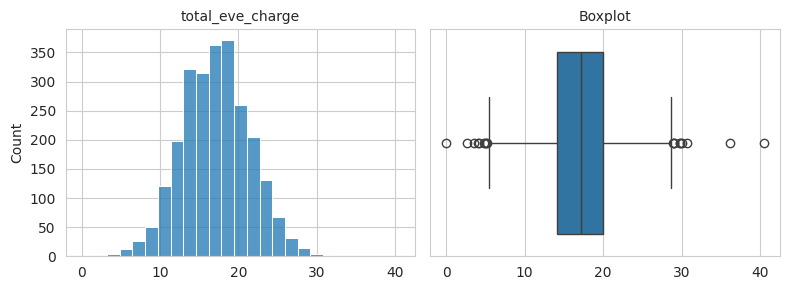

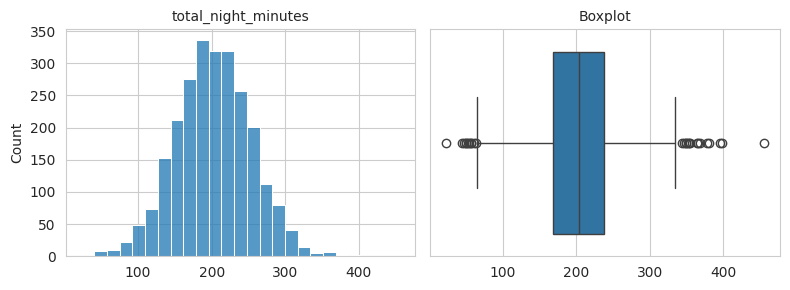

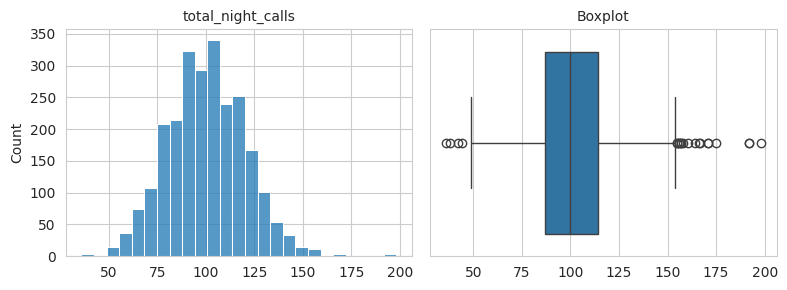

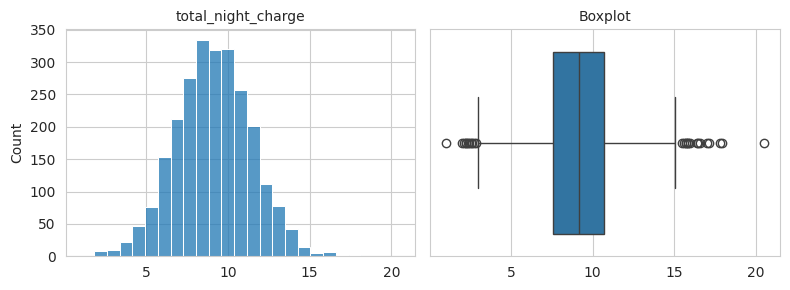

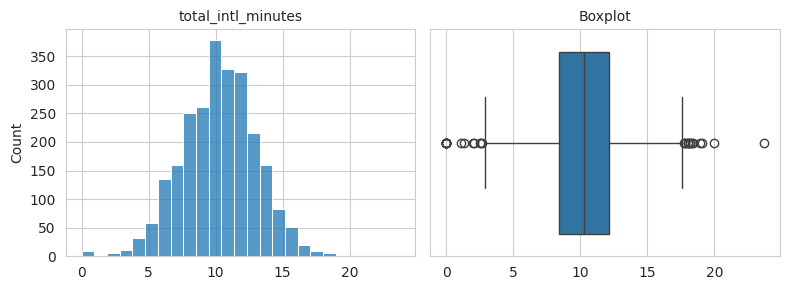

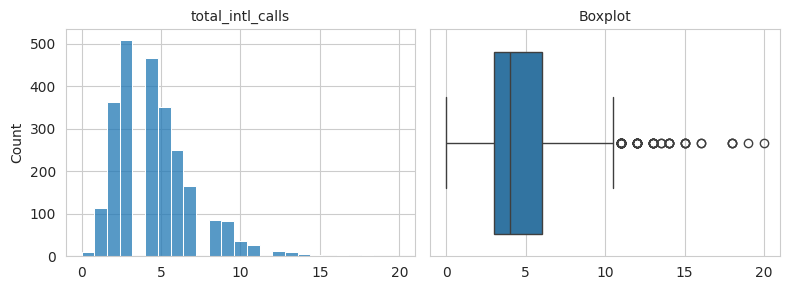

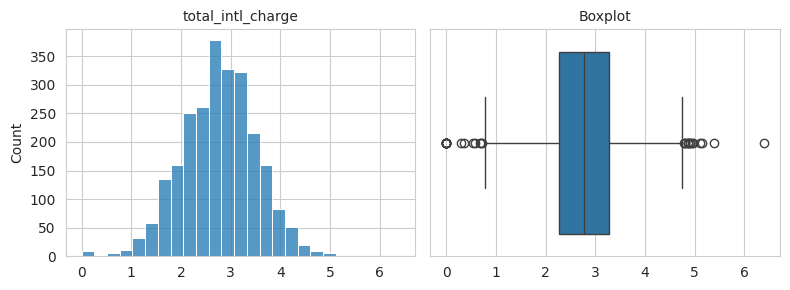

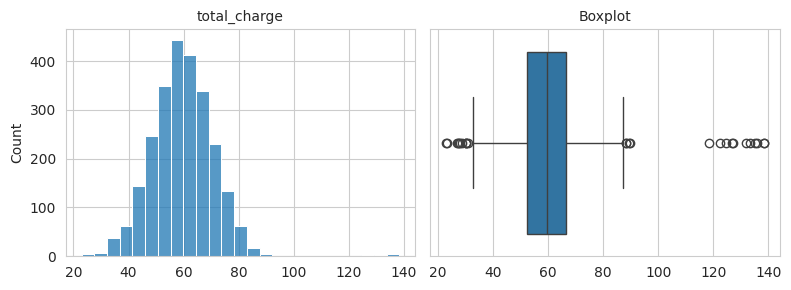

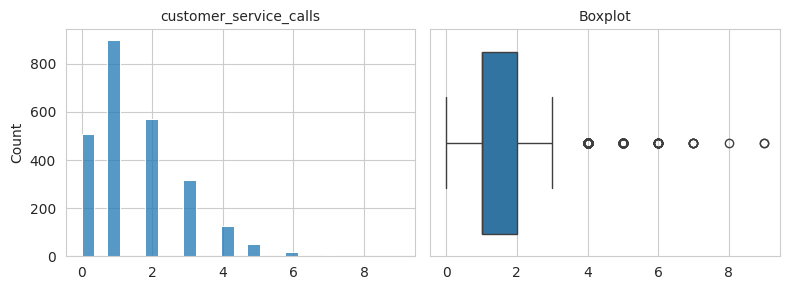

In [11]:
# RU / EN: Выбор числовых признаков
numeric_cols = train.select_dtypes(include=np.number).columns.drop('churn')

for col in numeric_cols:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    # Histogram
    sns.histplot(train[col], bins=25, ax=axes[0])
    axes[0].set_title(col, fontsize=10)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Count')
    
    # Boxplot
    sns.boxplot(x=train[col], ax=axes[1])
    axes[1].set_title('Boxplot', fontsize=10)
    axes[1].set_xlabel('')
    
    plt.tight_layout()
    plt.show()


## Лог-преобразование скошенных признаков | Log Transformation of Skewed Features

**RU:**  
Анализ распределений показал, что признаки `number_vmail_messages` и `customer_service_calls` имеют сильную правостороннюю асимметрию.  
Такие распределения могут негативно влиять на модели, чувствительные к масштабу признаков (логистическая регрессия, линейные модели).

Для уменьшения асимметрии и стабилизации масштаба применяется логарифмическое преобразование `log1p`, корректно работающее с нулевыми значениями.

**EN:**  
Distribution analysis revealed strong right skewness in the `number_vmail_messages` and `customer_service_calls` features.  
Such skewed distributions may negatively impact scale-sensitive models (e.g., logistic regression, linear models).

To reduce skewness and stabilize feature scale, a `log1p` transformation is applied, which safely handles zero values.


In [12]:
# RU / EN: Признаки с сильной правосторонней асимметрией
skewed_features = [
    'number_vmail_messages',
    'customer_service_calls'
]

# RU: Лог-преобразование с использованием log1p
# EN: Apply log1p transformation
for col in skewed_features:
    train[col] = np.log1p(train[col])
    test[col]  = np.log1p(test[col])

print("Лог-преобразование скошенных признаков выполнено.")


Лог-преобразование скошенных признаков выполнено.


## Проверка распределений после лог-преобразования | Post-Transformation Distribution Check


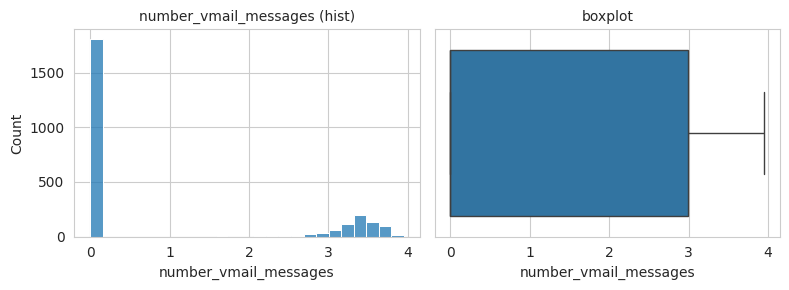

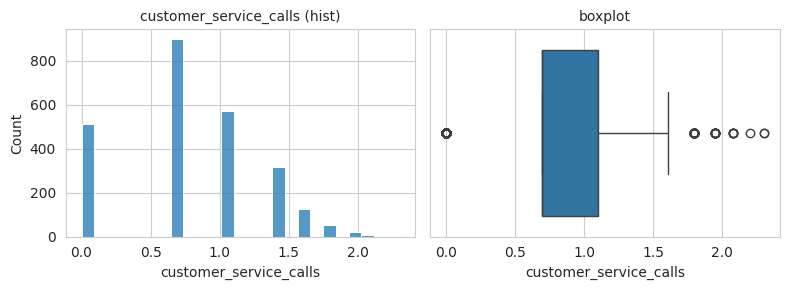

In [13]:
# RU / EN: Проверка распределений после лог-преобразования
for col in skewed_features:
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    
    sns.histplot(train[col], bins=25, ax=axes[0])
    axes[0].set_title(f'{col} (hist)', fontsize=10)
    
    sns.boxplot(x=train[col], ax=axes[1])
    axes[1].set_title('boxplot', fontsize=10)
    
    plt.tight_layout()
    plt.show()


## Анализ категориальных признаков | Categorical Feature Analysis

**RU:**  
Проанализируем категориальные признаки до кодирования для оценки распределений и выявления редких категорий.

**EN:**  
Let's analyze categorical features before coding to evaluate distributions and identify rare categories.


In [14]:
# RU / EN: Категориальные признаки
categorical_cols = train.select_dtypes(include='object').columns

for col in categorical_cols:
    print(f'\n--- {col.upper()} ---')
    print(train[col].value_counts(normalize=True).round(3))



--- SEX ---
sex
Female    0.505
Male      0.495
Name: proportion, dtype: float64

--- STATE ---
state
WV    0.032
MN    0.027
AL    0.025
WI    0.025
NY    0.025
OH    0.025
OR    0.024
WY    0.022
VT    0.022
VA    0.022
MT    0.022
ID    0.022
KS    0.022
AZ    0.021
CO    0.021
TX    0.021
MD    0.021
RI    0.021
UT    0.020
FL    0.020
NJ    0.020
CT    0.020
MI    0.020
MO    0.020
IN    0.020
NE    0.020
NC    0.020
MS    0.020
IL    0.019
WA    0.019
ME    0.019
ND    0.019
OK    0.019
KY    0.018
AR    0.018
DE    0.018
NV    0.018
NM    0.018
GA    0.018
MA    0.018
SC    0.017
DC    0.016
SD    0.016
HI    0.015
NH    0.015
AK    0.014
IA    0.014
TN    0.014
LA    0.014
PA    0.013
CA    0.010
Name: proportion, dtype: float64

--- PLANS ---
plans
international                0.653
Voice mail                   0.247
International                0.067
International, Voice mail    0.030
no plan                      0.003
Name: proportion, dtype: float64


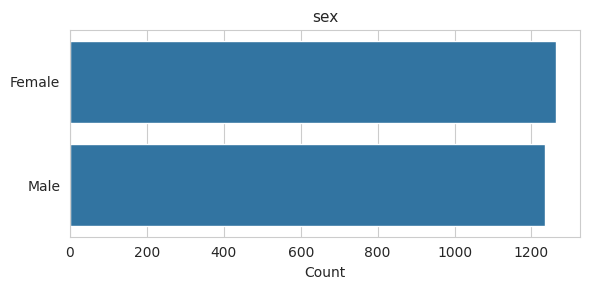

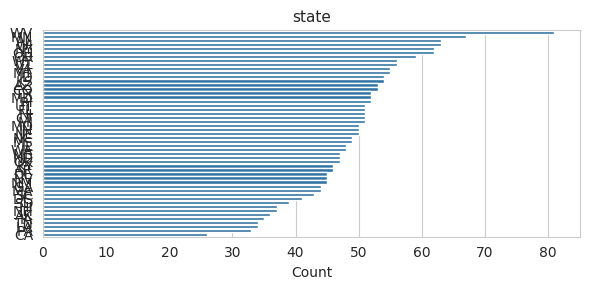

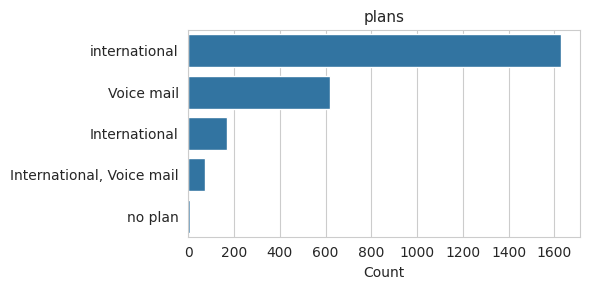

In [15]:
# RU / EN: Компактные countplot
for col in categorical_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(
        y=train[col],
        order=train[col].value_counts().index
    )
    plt.title(col, fontsize=11)
    plt.xlabel('Count')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()


## Продвинутая инженерия признаков и защита от утечек 

В данном блоке реализована логика обработки данных внутри кросс-валидации:

Target Encoding для 'State': Чтобы избежать переобучения при работе с географическими данными (51 уникальный штат), используется среднее значение целевой переменной. Расчет производится строго внутри каждого фолда, чтобы модель не "подсматривала" в будущее (Data Leakage).

One-Hot Encoding: Применяется для признаков с низкой мощностью (Sex, Plans) для корректной работы линейных и градиентных моделей.

Автоматическая очистка имен: Функция clean_feature_names обеспечивает совместимость со строгими требованиями библиотек LightGBM и XGBoost.

## Оптимизация бизнес-метрик и поиск порога 

Стандартный порог классификации (0.5) редко бывает оптимальным для задач оттока.

Threshold Tuning: Мы анализируем кривую Precision-Recall и находим порог, максимизирующий F1-score.

Это позволяет найти идеальный баланс: не пропускать уходящих клиентов (Recall), но и не тратить ресурсы на удержание тех, кто уходить не собирался (Precision).

In [20]:
# --- Утилиты для подготовки данных ---

def clean_feature_names(df):
    """Приведение имен признаков к стандарту (важно для LightGBM и XGBoost)"""
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(r'[^0-9a-zA-Z_]', '_', regex=True)
    )
    return df

def preprocess_fold(X_train, X_val, y_train):
    """
    Инженерия признаков внутри фолда:
    1. Target Encoding для State (защита от утечки данных)
    2. One-Hot Encoding для категориальных планов
    3. Очистка имен колонок
    """
    # Target Encoding
    state_target_mean = y_train.groupby(X_train['state']).mean()
    global_mean = y_train.mean()
    X_train['state_te'] = X_train['state'].map(state_target_mean).fillna(global_mean)
    X_val['state_te'] = X_val['state'].map(state_target_mean).fillna(global_mean)
    X_train.drop('state', axis=1, inplace=True)
    X_val.drop('state', axis=1, inplace=True)
    
    # One-Hot Encoding
    ohe_features = ['plans', 'sex']
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe.fit(X_train[ohe_features])
    
    X_train_ohe = pd.DataFrame(ohe.transform(X_train[ohe_features]), 
                               columns=ohe.get_feature_names_out(ohe_features), index=X_train.index)
    X_val_ohe = pd.DataFrame(ohe.transform(X_val[ohe_features]), 
                             columns=ohe.get_feature_names_out(ohe_features), index=X_val.index)
    
    X_train = pd.concat([X_train.drop(ohe_features, axis=1), X_train_ohe], axis=1)
    X_val = pd.concat([X_val.drop(ohe_features, axis=1), X_val_ohe], axis=1)
    
    return clean_feature_names(X_train), clean_feature_names(X_val)

def compute_metrics(y_true, y_proba):
    """Расчет ROC AUC и поиск оптимального порога для максимизации F1-score"""
    roc_auc = roc_auc_score(y_true, y_proba)
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    
    best_threshold = thresholds[best_idx]
    y_pred = (y_proba >= best_threshold).astype(int)
    report = classification_report(y_true, y_pred, output_dict=True)
    
    return {
        'roc_auc': roc_auc,
        'best_threshold': best_threshold,
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score']
    }

## Обучение градиентного бустинга (GBDT)
Advanced GBDT Training

Настройка «большой тройки» библиотек бустинга. Главная особенность — динамическая балансировка классов через scale_pos_weight для работы с несбалансированным таргетом. Используются унифицированные параметры (глубина 4, learning rate 0.05) и Early Stopping для предотвращения переобучения.

In [22]:
def train_xgboost(X_train, y_train, X_val, y_val):
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    params = {
        'objective': 'binary:logistic', 'eval_metric': 'auc',
        'scale_pos_weight': scale_pos_weight, 'learning_rate': 0.05,
        'max_depth': 4, 'tree_method': 'hist', 'seed': 42, 'verbosity': 0
    }
    bst = xgb.train(params, dtrain, num_boost_round=500,
                    evals=[(dval, 'eval')], early_stopping_rounds=50, verbose_eval=False)
    return compute_metrics(y_val, bst.predict(dval))

def train_lightgbm(X_train, y_train, X_val, y_val):
    model = LGBMClassifier(verbosity=-1, n_estimators=500, learning_rate=0.05, max_depth=4,
                           scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), random_state=42)
    model.fit(X_train, y_train)
    return compute_metrics(y_val, model.predict_proba(X_val)[:, 1])

def train_catboost(X_train, y_train, X_val, y_val):
    model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=4,
                               scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
                               eval_metric='AUC', random_seed=42, verbose=False)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)
    return compute_metrics(y_val, model.predict_proba(X_val)[:, 1])

## Кросс-валидация и выбор лучшей модели

Финальный этап оценки моделей с использованием Stratified K-Fold (5 фолдов):

Валидация внутри цикла: Препроцессинг и масштабирование (StandardScaler) применяются отдельно к каждому фолду, что гарантирует честность метрик.

Сравнение алгоритмов: В одном цикле тестируются базовые классификаторы (LogReg, Random Forest, Gradient Boosting) и специализированные бустинги.

Итоговый лидерборд: Агрегация результатов по всем фолдам и сортировка по ROC AUC для выбора наиболее стабильной модели.

In [25]:
X = train.drop('churn', axis=1)
y = train['churn']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"Processing Fold {fold}...", end="\r")
    X_train_fold, X_val_fold = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # 1. Препроцессинг внутри фолда
    X_train_fold, X_val_fold = preprocess_fold(X_train_fold, X_val_fold, y_train_fold)
    
    # 2. Масштабирование (только для линейных моделей)
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train_fold)
    X_val_sc = scaler.transform(X_val_fold)
    
    # 3. Цикл обучения моделей
    fold_models = {
        'LogReg': (LogisticRegression(max_iter=2000, class_weight='balanced'), X_train_sc, X_val_sc),
        'RF': (RandomForestClassifier(n_estimators=300, random_state=42), X_train_fold, X_val_fold),
        'GB': (GradientBoostingClassifier(random_state=42), X_train_fold, X_val_fold)
    }
    
    for name, (model, xt, xv) in fold_models.items():
        res = compute_metrics(y_val_fold, model.fit(xt, y_train_fold).predict_proba(xv)[:, 1])
        res.update({'fold': fold, 'model': name})
        results.append(res)
        
    # Специфичные модели (XGB, LGBM, Cat)
    results.append({**train_xgboost(X_train_fold, y_train_fold, X_val_fold, y_val_fold), 'fold': fold, 'model': 'XGBoost'})
    results.append({**train_lightgbm(X_train_fold, y_train_fold, X_val_fold, y_val_fold), 'fold': fold, 'model': 'LightGBM'})
    results.append({**train_catboost(X_train_fold, y_train_fold, X_val_fold, y_val_fold), 'fold': fold, 'model': 'CatBoost'})

# Итоговая таблица
summary = pd.DataFrame(results).groupby('model').mean(numeric_only=True).drop(columns='fold')
print("\n===== Итоговые результаты Cross-Validation =====")
display(summary.sort_values('roc_auc', ascending=False))

Processing Fold 5...
===== Итоговые результаты Cross-Validation =====


,roc_auc,best_threshold,precision,recall,f1
model,,,,,
GB,0.912657,0.351946,0.938091,0.836872,0.884354
RF,0.909204,0.286667,0.913645,0.809209,0.857055
CatBoost,0.907703,0.609088,0.908300,0.784551,0.838949
LightGBM,0.906256,0.581361,0.976552,0.806355,0.882194
XGBoost,0.905091,0.587611,0.980213,0.792428,0.874524
LogReg,0.756634,0.610605,0.376072,0.555632,0.444590


In [27]:
# ==========================================
# ФИНАЛЬНОЕ ОБУЧЕНИЕ И СОЗДАНИЕ SUBMISSION (ВЕРОЯТНОСТИ)
# ==========================================

# 1. Подготовка данных
X_final = train.drop('churn', axis=1)
y_final = train['churn']
X_test_sub = test.copy()

# 2. Финальный препроцессинг (Target Encoding и OHE)
X_train_ready, X_test_ready = preprocess_fold(X_final.copy(), X_test_sub.copy(), y_final)

# 3. Вес классов для баланса
scale = (y_final == 0).sum() / (y_final == 1).sum()

# 4. Модель (LightGBM)
final_model = LGBMClassifier(
    n_estimators=500, 
    learning_rate=0.05, 
    max_depth=4,
    scale_pos_weight=scale, 
    random_state=42, 
    verbosity=-1
)

# 5. Обучение на всех данных
final_model.fit(X_train_ready, y_final)

# 6. Получение ВЕРОЯТНОСТЕЙ (Probability)
# Используем [:, 1], чтобы взять вероятность именно "оттока" (класса 1)
final_probs = final_model.predict_proba(X_test_ready)[:, 1]

# 7. Формирование файла с правильными названиями колонок
# Регистр важен: ID и Churn
submission = pd.DataFrame({
    'ID': test_ids, 
    'Churn': final_probs
})

# Сохранение
submission.to_csv('submission_probs.csv', index=False)

print("Файл submission_probs.csv успешно сформирован!")
print("\nПервые 5 строк сабмита:")
print(submission.head())

Файл submission_probs.csv успешно сформирован!

Первые 5 строк сабмита:
      ID     Churn
0  10007  0.088613
1  10134  0.013256
2  10464  0.026339
3  10490  0.139643
4  10556  0.016423
